# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 13 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 13 марта, -4 балла после 06:00 20 марта, -6 баллов после 06:00 27 марта

Отправлять дз не нужно, нужно закоммитить в github. Сдается дз лично преподавателю на рубежном контроле (13 марта)

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

Основная задача этого задания - реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [227]:
import math
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Реализация алгоритма

Cчитываем данные, полученные в результате выполнения домашнего задания из курса введения, в `data frame` библиотеки `pandas`. Достаем координаты и конвертируем в массив `numpy`. Возможно, в собранном вами файле кодировка будет иной.

In [204]:
data_df = pd.read_csv("checkins.csv", sep=",", header=0, encoding='windows-1251')
data_df.drop(u'Unnamed: 0' , axis=1, inplace=True)
data_df.head()

,address,checkins,city,country,created,icon,latitude,longitude,pid,title,type,updated
0,Мячковский б-р 3а,435,1,1,1280741941,https://vk.com/images/places/clubs.png,55.657941,37.751574,1,Baila Baila,4,1.487519e+09
1,Дачная 2а,14,123,1,1280741941,https://vk.com/images/places/clubs.png,53.202017,50.141377,2,Lust,4,1.483478e+09
2,Лени Голикова 29,8,2,1,1280741941,https://vk.com/images/places/clubs.png,59.843376,30.231480,3,Тайфун,4,1.486398e+09
3,Героев Танкограда 63,8,158,1,1280741941,https://vk.com/images/places/clubs.png,55.174954,61.451611,4,Hollywood,4,1.470157e+09
4,Мусы Джалиля 14К1,38,99,1,1280741941,https://vk.com/images/places/clubs.png,54.860834,83.091932,5,Барабас,4,1.488720e+09


In [205]:
X = data_df[['latitude', 'longitude']].values
print X

[[ 55.657941  37.751574]
 [ 53.202017  50.141377]
 [ 59.843376  30.23148 ]
 ..., 
 [ 55.76363   37.597046]
 [ 56.002732  37.209755]
 [ 47.225695  39.72997 ]]


Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего порядкового номера в списке группы.

1 Баранчиков Максим	
2 Бекбулатов Рамзан	
3 Белозёров Михаил	
4 Бобылев Владислав	
5 Брызгалов Антон	
6 Будюк Алексей	
7 Валиуллин Альберт	
8 Валиуллин Артур	
9 Васильев Евгений	
10 Галицкий Игорь	
11 Горшков Сергей	
12 Гусев Вячеслав	
13 Дегтярев Роман	
14 Дементьев Максим	
15 Елохов Артур	
16 Ефимов Владислав	
17 Зайцев Александр	
18 Ильин Иван	
19 Имеев Мерген	
20 Камалбеков Тимур	
21 Капитонов Александр	
22 Каспарьянц Георгий	
23 Кафанов Олег	
24 Клейменов Андрей	
25 Козлов Иван	
26 Колмакова Татьяна	
27 Комов Евгений	
28 Крылов Иван	
29 Кузьмина Ирина	
30 Куклева Анна	
31 Курьянов Илья	
32 Лобанов Алексей	
33 Лозинский Иван	
34 Лузин Игорь	
35 Лукьянчиков Иван	
36 Неред Максим	
37 Новикова Анастасия	
38 Новичков Сергей	
39 Омаров Темирхан	
40 Павлова Анастасия	
41 Петренко Иван	
42 Пилюгин Вадим	
43 Плошкин Александр	
44 Полякова Вера	
45 Попкова Екатерина	
46 Преображенский Анатолий	
47 Пронин Сергей	
48 Пучкин Данила	
49 Рогачев Александр	
50 Руденко Дмитрий	
51 Рыбаков Владислав	
52 Санников Артём	
53 Скиба Глеб	
54 Страдомский Сергей	
55 Тескер Константин	
56 Трифанов Петр	
57 Хапкин Артем	
58 Хорошенький Илья	
59 Чокля Дмитрий	
60 Шмурак Денис	
61 Щербакова Елена	

In [4]:
N = 15 # put your index here

In [5]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'OPTICS. (параметры - epsilon, min_pts)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [214]:
from sklearn.base import BaseEstimator, ClusterMixin

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    def __init__(self, eps=1.0, min_pts=3):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.eps = eps
        self.min_pts = min_pts
        self.Reachability_distance_list = []
        self.Core_distance_list = []
        self.Points_list = []
        return
    
    class Priority_queue():
        def __init__(self):
            self.queue = []

        def empty(self):
            return (not self.queue)

        def pop(self):
            return self.queue.pop()[1]

        def put(self, priority, value):
            if(not(self.queue)): 
                self.queue.append([priority, value])
            else:
                lenght = len(self.queue)
                i = 0
                while(i < lenght):
                    if(self.queue[i][0] < priority):
                        self.queue.insert(i , [priority, value])
                        break
                    else:
                        i += 1
                if(lenght == len(self.queue)):
                    self.queue.append([priority, value])
            return

        def change_priority(self, new_priority, value):
            for i in xrange(0, len(self.queue)):
                if(self.queue[i][1] == value):
                    self.queue.pop(i)
                    self.put(new_priority, value)
            return
                    
    def get_neighbors(self, X, p):
        result = []
        for q in xrange(0, X.shape[0]):
            if (0 < smt.pairwise.pairwise_distances(X[p, :].reshape(1, -1) , X[q, :].reshape(1, -1)) <= self.eps):
                result.append(q)
        return np.array(result)
    
    def core_distance(self, X, p):
        N = self.get_neighbors(X, p)
        if(N.size + 1 < self.min_pts):
            return NaN
        else:
            mindist = smt.pairwise.pairwise_distances(X[p, :].reshape(1, -1) , X[N[0], :].reshape(1, -1))
            for i in xrange(0, N.shape[0]):
                q = N[i]
                dist = smt.pairwise.pairwise_distances(X[p, :].reshape(1, -1) , X[q, :].reshape(1, -1))
                if (dist <= mindist):
                    mindist = dist
            return mindist
    
    def update(self, X, N, p, Seeds, Mark, Reachability_distance):
        coredist = self.Core_distance_list[p]
        for i in xrange(0, N.shape[0]):
            q = N[i]
            if(Mark[q] == 0):
                new_reach_dist = max(coredist, smt.pairwise.pairwise_distances(X[p, :].reshape(1, -1) , X[q, :].reshape(1, -1)))
                if(math.isnan(Reachability_distance[q])): #q is not in Seeds
                    Reachability_distance[q] = new_reach_dist
                    Seeds.put(new_reach_dist, q)
                else: #q in Seeds, check for improvement
                    if(new_reach_dist < Reachability_distance[q]):
                        Reachability_distance[q] = new_reach_dist
                        Seeds.change_priority(new_reach_dist, q)
        return 
    
    def optics(self, X):
        Reachability_distance = np.empty(X.shape[0])
        Reachability_distance[:] = numpy.NAN
        Mark = np.zeros((X.shape[0], 1))
        List = []
        for q in xrange(X.shape[0]):
            self.Core_distance_list.append(self.core_distance(X, q))
        for p in xrange(0, Mark.shape[0]):
            if(Mark[p] == 0):
                N = self.get_neighbors(X, p)
                Mark[p] = 1
                List.append(p)
                if(not math.isnan(self.Core_distance_list[p])):
                    Seeds = self.Priority_queue()
                    self.update(X, N, p, Seeds, Mark, Reachability_distance)
                    while(not Seeds.empty()):
                        q = Seeds.pop()
                        N1 = self.get_neighbors(X, q)
                        Mark[q] = 1
                        List.append(q)
                        if (not math.isnan(self.Core_distance_list[q])):
                            self.update(X, N1, q, Seeds, Mark, Reachability_distance)
        return (List, Reachability_distance)
                    
    def fit(self, X, y=None):
        """
        Use data matrix X to compute model parameters
        """
        self.Points_list, Reachability_distance = self.optics(X)
        self.Reachability_distance_list = Reachability_distance.tolist()
        return self
    
    def reachability_plot(self, threshold=None, width=1.0):
        lenght = len(self.Points_list)
        y_axis = np.empty(lenght)
        for i in xrange(lenght):
            y_axis[i] = self.Reachability_distance_list[self.Points_list[i]]
        x_axis = np.linspace(0, lenght - 1, lenght)
        plt.figure()
        plt.bar(x_axis, y_axis, width=width, color = 'black')
        plt.title('Reachability plot')
        plt.xlabel('ordered points')
        plt.ylabel('reachability distance')
        if(threshold != None):
            y_threshold = np.zeros(lenght)
            y_threshold += threshold
            plt.plot(x_axis, y_threshold)
            plt.legend(['threshold'])
        plt.show()
        return 
        
    def extract_by_range(self, rangelist):
        y = [0 for r in xrange(rangelist[0][0])]
        for i in xrange(len(rangelist) - 1):
            y += [(i + 1) for r in xrange(rangelist[i][0], rangelist[i][1])]
            y += [0 for r in xrange(rangelist[i][1], rangelist[i + 1][0])]
        k = len(rangelist) - 1
        y += [(k + 1) for r in xrange(rangelist[k][0], rangelist[k][1])]
        y += [0 for r in xrange(rangelist[k][1], len(self.Points_list))]
        return (np.array(y)).astype(int)
    
    def extract_by_threshold(self, threshold):
        y = np.zeros(len(self.Points_list))
        clusterId = 0
        for i in self.Points_list:
            if(self.Reachability_distance_list[i] > threshold):
                if(self.Core_distance_list[i] <= threshold):
                    clusterId += 1
                    y[i] = clusterId
                else:
                    y[i] = 0
            else:
                y[i] = clusterId
        return y.astype(int)
    
    def predict(self, X, var='threshold', threshold=1.0, plot=False, x_range=None):
        """
        Using computed model parameters predict cluster
        for all objects from X
        """
        if(var == 'threshold'):
            y = self.extract_by_threshold(threshold)
            if(plot == True):
                self.reachability_plot(threshold)
        elif(var == 'range'):
            y = self.extract_by_range(x_range)
        else:
            y = (np.zeros(X.shape[0])).astype(int)
        
        return y
    
    def fit_predict(self, X, y=None, var='threshold', threshold=1.0, plot=False, x_range=None):
        self.fit(X, y)
        return self.predict(X, var, threshold, plot, x_range)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

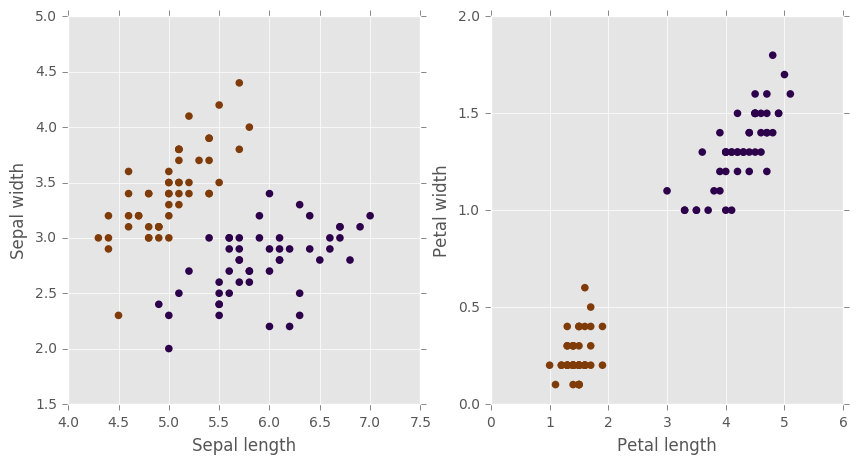

In [195]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

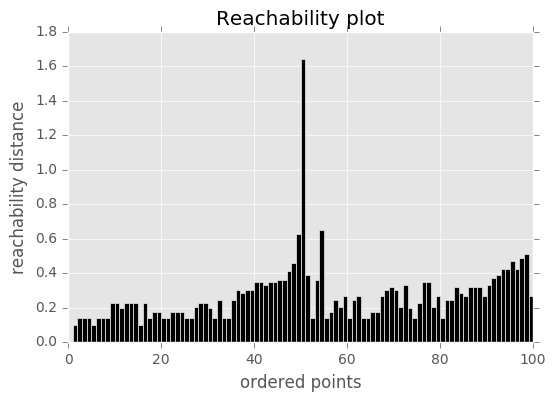

In [196]:
clt = Clustering(eps = 3.0)
clt.fit(x_iris)
clt.reachability_plot()

In [197]:
#кластеризация по разрезанию оси X
pred_iris = clt.predict(x_iris, var='range', x_range=[[0, 50], [50, 100]])
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


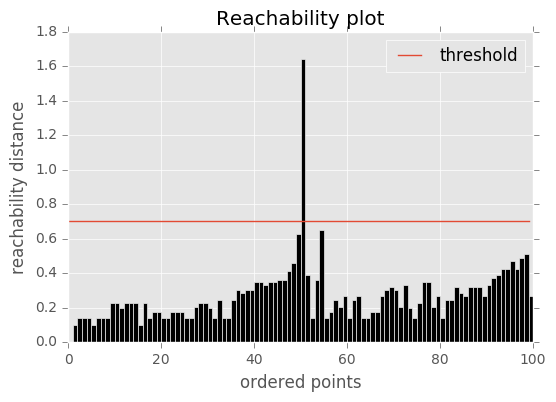

Adjusted Rand index for iris is: 1.00


In [198]:
#кластеризация по пороговому значению на оси Y
pred_iris = clt.predict(x_iris, var='threshold', plot=True, threshold=0.7)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Silhouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [199]:
def quality(x, labels):
    """
    Implement quality criterion of your choice
    """
    distances = smt.pairwise_distances(x)
    n = labels.shape[0]
    A = np.zeros(n)
    B = np.zeros(n)
    for i in xrange(n):
        mask = labels == labels[i]
        mask[i] = False
        if not np.any(mask):
            # cluster of size 1
            return 0
        A[i] = np.mean(distances[i][mask])
        B[i] = np.min([np.mean(distances[i][labels == cur_label])
                   for cur_label in set(labels) if not cur_label == labels[i]])
    
    sil_samples = (B - A) / np.maximum(A, B)
    return np.mean(sil_samples)

In [200]:
silhouette = quality(x_iris, pred_iris)
print silhouette

0.736936816068


Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

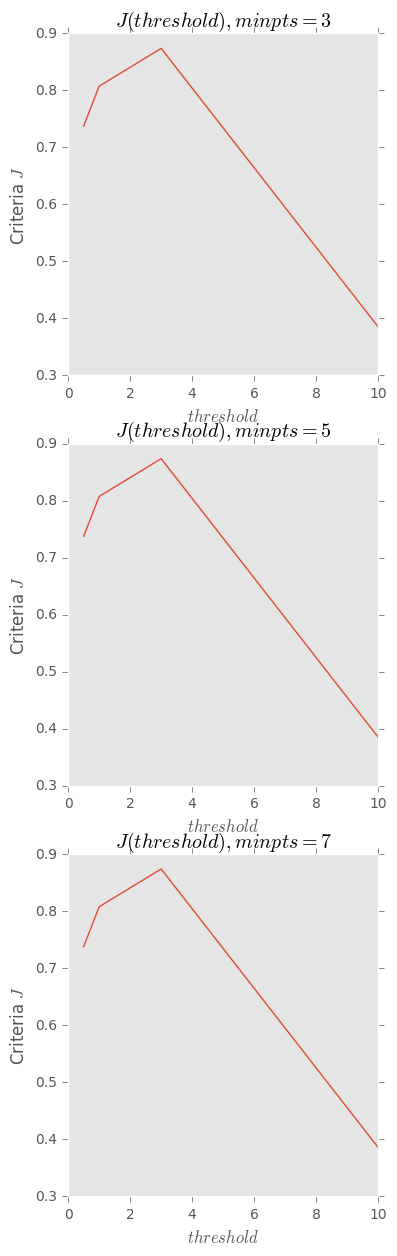

In [201]:
#максимизируем по threshold с фиксированными min_pts
epsilon = 50.0
threshold = (0.5, 1.0, 3.0, 10.0)
min_points = (3, 5, 7)
j = 1
criteria = np.zeros(len(threshold))
ks = np.array(threshold)
plt.figure(figsize=(4, 15))
for min_pts in min_points:
    i = 0
    for ei in threshold:
        cls = Clustering(eps=epsilon, min_pts=min_pts)
        cls.fit(X[0:250, :])
        y = cls.predict(X[0:250, :], var='threshold', threshold=ei)
        criteria[i] = quality(X[0:250, :], y)
        i += 1
    plt.subplot(3, 1, j)
    plt.plot(ks, criteria)
    plt.title("$J(threshold), minpts = {}$".format(min_pts))
    plt.ylabel("Criteria $J$")
    plt.xlabel("$threshold$")
    plt.grid()
    j += 1

plt.show()

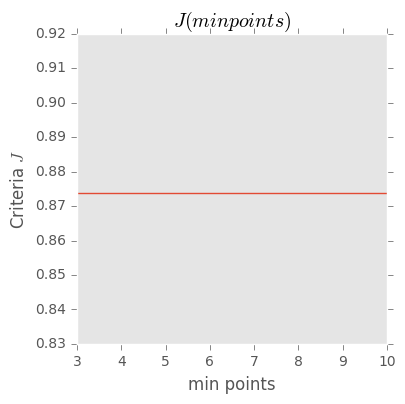

In [202]:
#максимизируем по min_pts
best_threshold = 3.0
min_points = (3, 4, 5, 7, 10)
i = 0
criteria = np.zeros(len(min_points))
ks = np.array(min_points)
for min_pts in min_points:
    cls = Clustering(eps=epsilon, min_pts=min_pts)
    cls.fit(X[0:250, :])
    y = cls.predict(X[0:250, :], var='threshold', threshold=best_threshold)
    criteria[i] = quality(X[0:250, :], y)
    i += 1
plt.figure(figsize=(4, 4))
plt.plot(ks, criteria)
plt.title("$J(min points)$")
plt.ylabel("Criteria $J$")
plt.xlabel("min points")
plt.grid()
plt.show()

In [ ]:
#min_points в данном диапазоне не влияет на результат

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

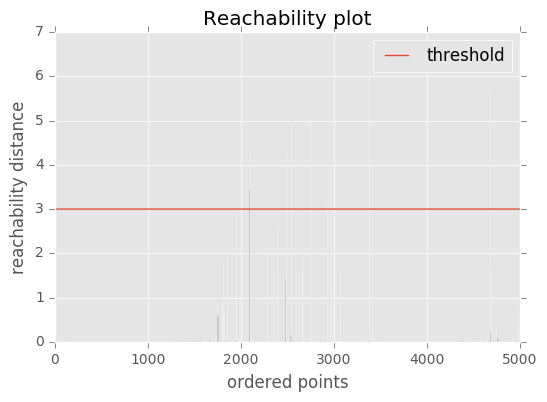

In [206]:
epsilon = 10.0
threshold = 3.0
min_points = 4
cls = Clustering(eps=epsilon, min_pts=min_points)
y = cls.fit_predict(X, threshold=threshold, plot=True)

In [226]:
print "quality = %f" %quality(X, y)
print "number of clusters = %d" %np.max(y)

quality = 0.786654
number of clusters = 9


In [216]:
model = sm.TSNE()
X_new = model.fit_transform(X)
print X.shape
print X_new.shape

(5000, 2)
(5000, 2)


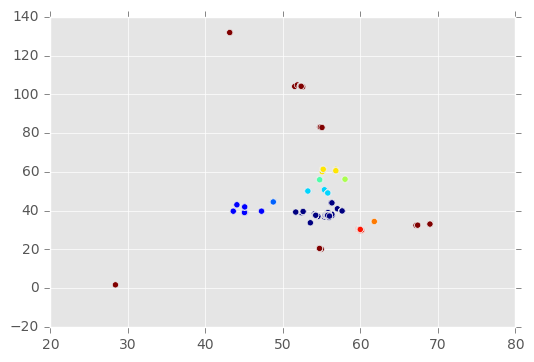

In [221]:
pl.scatter(X[:, 0], X[:, 1], c=y)

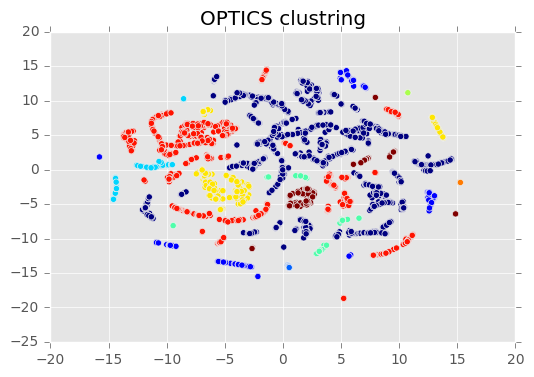

In [225]:
pl.figure()
pl.scatter(X_new[:, 0], X_new[:, 1], c=y)
pl.title('OPTICS clustring')
pl.show()

Визуализируем кластеризацию на карте

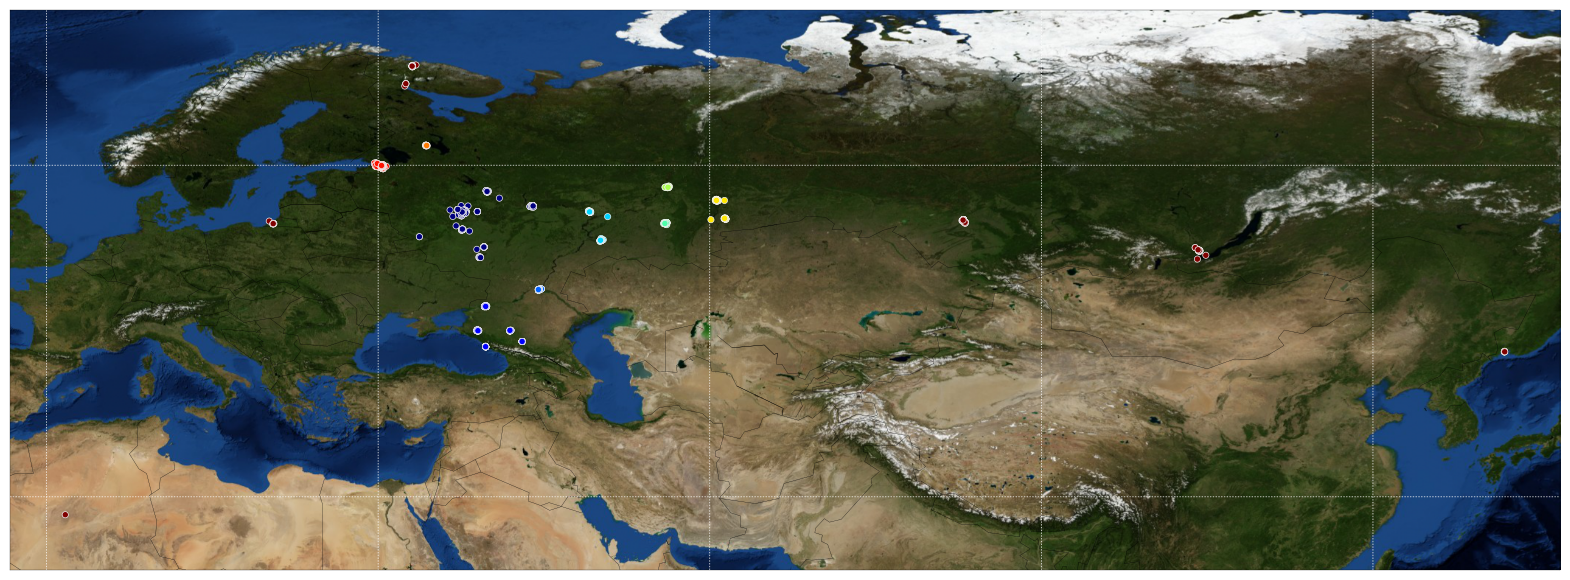

In [241]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(X[:, 0]) - 5, urcrnrlat=max(X[:, 0]) + 5, llcrnrlon=min(X[:, 1]) - 5, urcrnrlon=max(X[:, 1]) + 5, resolution='c')

m.drawcountries(linewidth=0.2)
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.bluemarble()
m.scatter(X[:, 1], X[:,0], c=y, zorder=10)
    
pl.show()

Визуализируйте интересные участки (может быть это Москва) в приближенном виде. Постройте 3 (или более, в зависимости от данных, что вам самим бы хотелось увидеть ближе) увеличенных изображений карты с кластеризацией.

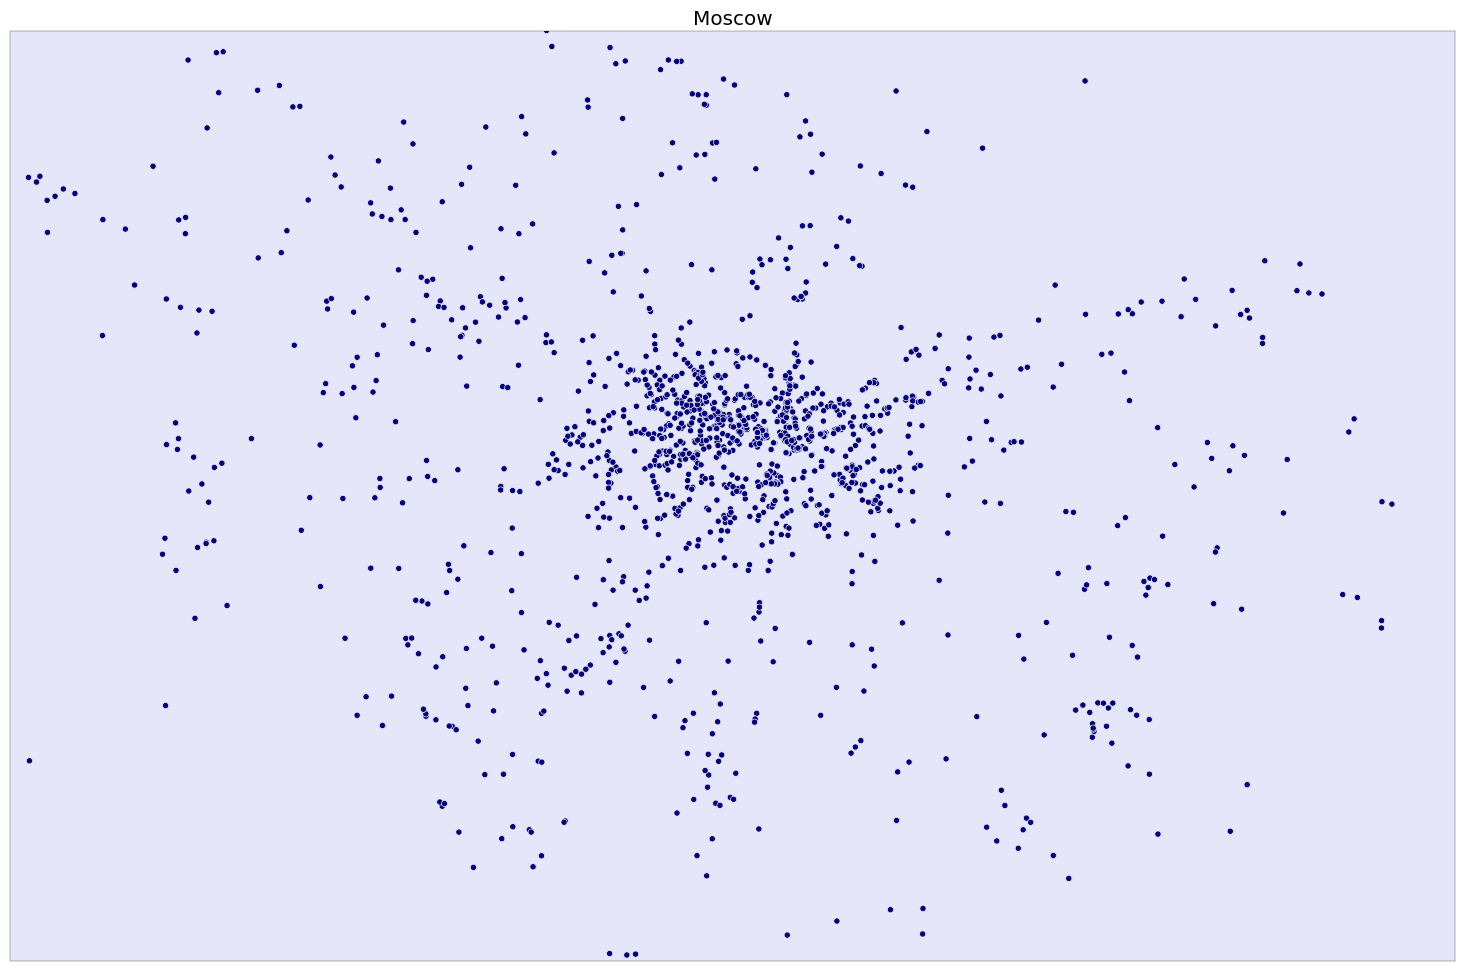

In [243]:
# your code with maps here
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=55.564141, urcrnrlat=55.908930, llcrnrlon=37.344362, urcrnrlon=37.879945, resolution='h')
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawcountries(linewidth=0.2)
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(X[:, 1], X[:,0], c=y, zorder=10)
pl.title('Moscow')    
pl.show()


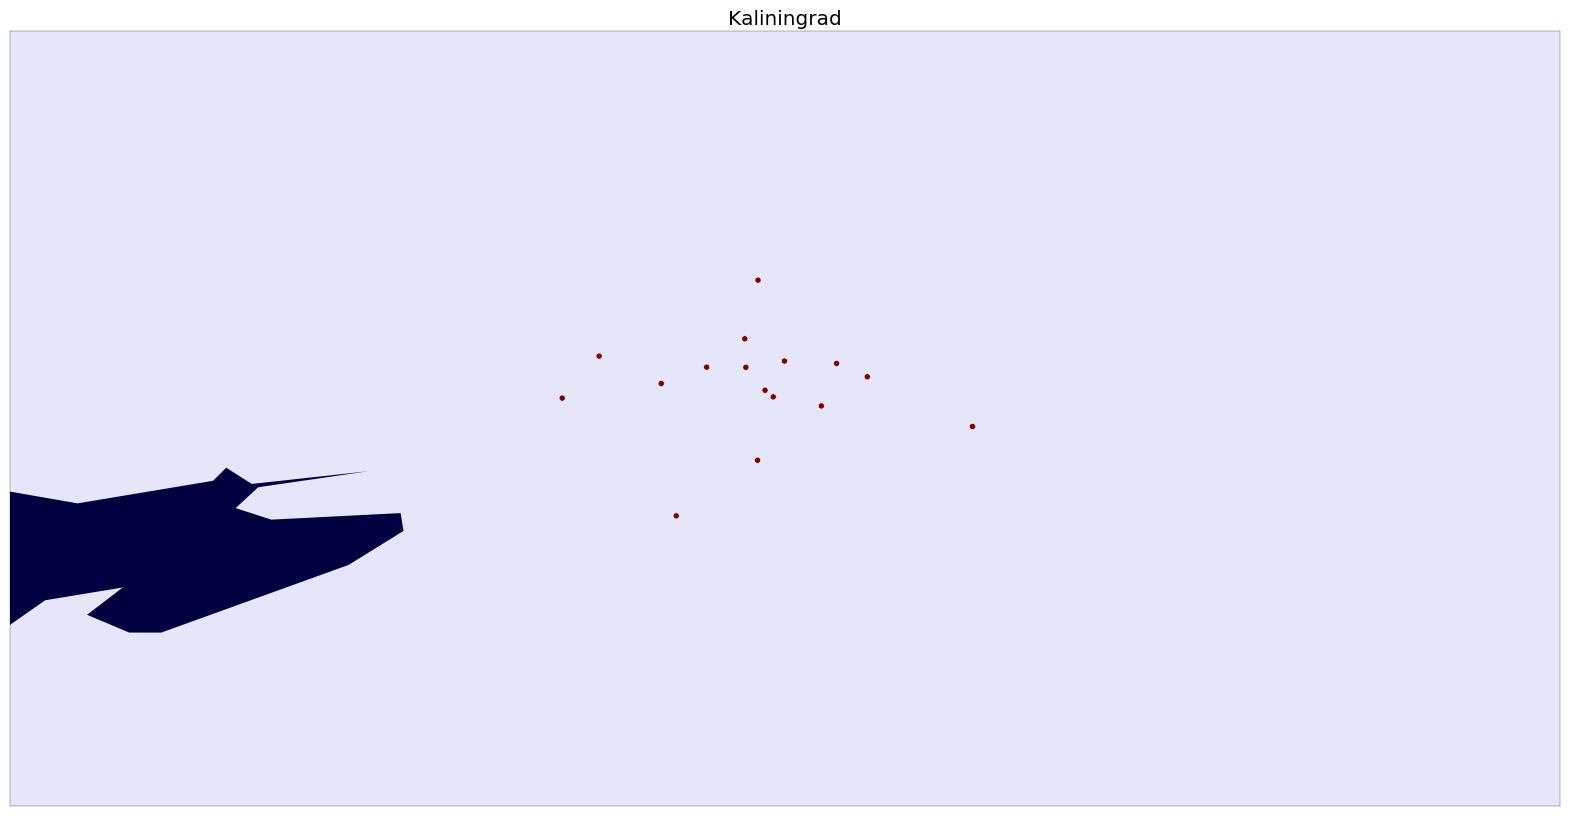

In [250]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=54.60649, urcrnrlat=54.80649, llcrnrlon=20.31095, urcrnrlon=20.71095, resolution='h')
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawcountries(linewidth=0.2)
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(X[:, 1], X[:,0], c=y, zorder=10)
pl.title('Kaliningrad')    
pl.show()

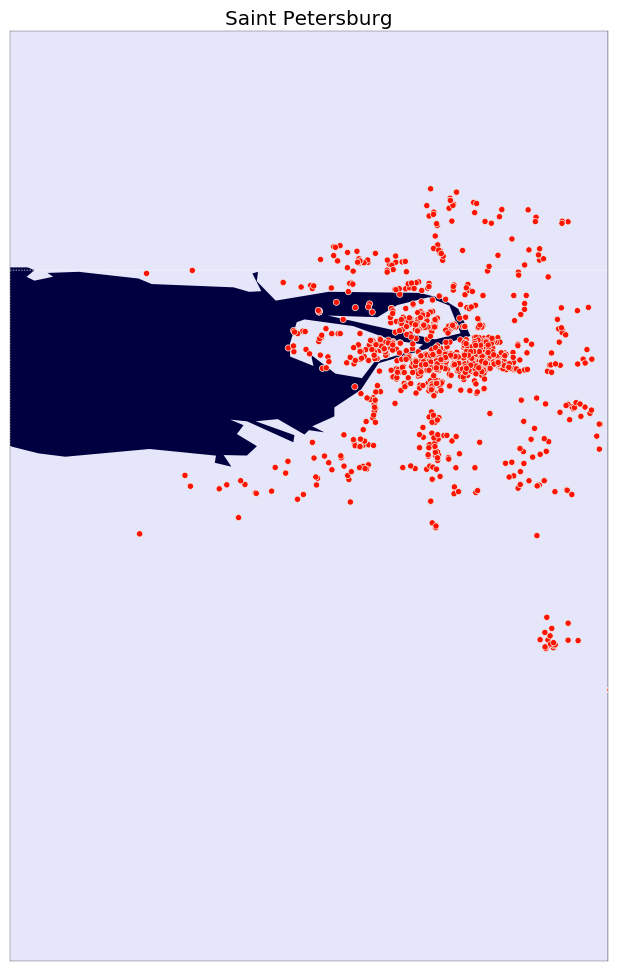

In [257]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=59.48, urcrnrlat=60.18, llcrnrlon=30.0, urcrnrlon=30.45, resolution='h')
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawcountries(linewidth=0.2)
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(X[:, 1], X[:,0], c=y, zorder=10)
pl.title('Saint Petersburg')    
pl.show()

Какой вывод можно сделать о качестве кластеризации?

Алгоритм кластеризации позволил выделить отдельные очень плотные кластеры - большие города, такие как Москва, Санкт-Петербург.
В остальных районах алгоритм объединил в кластеры целые области, что не очень полезно с практической точки зрения.

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.